In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline
#sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import zipfile
import imageio
import os

import umap
import MulticoreTSNE
import time

import sklearn.manifold
sns.set(context='poster', rc={'figure.figsize':(12, 10)})

### Pull the data from the internet and write it to a file

In [2]:
%%time
if not os.path.isfile('coil20.zip'):
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip')
    with open("coil20.zip", "wb") as code:
        code.write(results.content)

CPU times: user 106 µs, sys: 47 µs, total: 153 µs
Wall time: 120 µs


### Read in from file and transform into a vector space

We add a filter to ensure that we only parse png files from our download zip.

In [3]:
import re
images_zip = zipfile.ZipFile('coil20.zip')
mylist = images_zip.namelist()
r = re.compile(".*\.png$")
filelist = list(filter(r.match, mylist))

Next we pull the object id's from the file names using pandas

In [4]:
if not os.path.isfile('coil-20-proc/obj10__1.png'):
    !unzip coil20.zip

In [5]:
%%time
feature_vectors = []
for filename in filelist:
    im = imageio.imread(filename)
    feature_vectors.append(im.flatten())

CPU times: user 811 ms, sys: 310 ms, total: 1.12 s
Wall time: 1.43 s


### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

We could leave this data in numpy arrays for improved efficiency but at data sizes this small the added functionality of pandas for potential exploration is appealing.

In [6]:
labels = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False)

In [7]:
data = np.array(pd.DataFrame(feature_vectors, index=labels))
data.shape

(1440, 16384)

### Now let's use UMAP to embed these points into a two dimensional space.

In [8]:
timings = []
dims = []
dimensions = [2,4,6,8]
for dim in dimensions:
    for rep in range(5):
        start = time.time()
        embedding = umap.UMAP(n_components=dim, n_neighbors=5, metric='euclidean').fit_transform(data)
        total_time = time.time()- start
        dims.append(dim)
        timings.append(total_time)
        print("dim: {} timing:{}".format(dim,total_time))

    

dim: 2 timing:5.8010780811309814
dim: 2 timing:2.158696174621582
dim: 2 timing:2.1505839824676514
dim: 2 timing:2.182827949523926
dim: 2 timing:2.198530912399292
dim: 4 timing:2.3100039958953857
dim: 4 timing:2.403096914291382
dim: 4 timing:2.437175989151001
dim: 4 timing:2.3927488327026367
dim: 4 timing:2.3516769409179688
dim: 6 timing:2.5335659980773926
dim: 6 timing:2.5342659950256348
dim: 6 timing:2.484616994857788
dim: 6 timing:2.465701103210449
dim: 6 timing:2.5042409896850586
dim: 8 timing:2.5367109775543213
dim: 8 timing:2.649115800857544
dim: 8 timing:2.5686380863189697
dim: 8 timing:2.566833019256592
dim: 8 timing:2.572356939315796


In [9]:
d_umap = pd.DataFrame({'dimension':dims,'timing':timings})

### T-SNE

In [10]:
tsne_timings = []
tsne_dims = []
dimensions = [2,4,6,8]
for dim in dimensions:
    for rep in range(5):
        start = time.time()
        fit_tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=1, n_components=dim).fit_transform(data)
        #embedding = umap.UMAP(n_components=dim, n_neighbors=5, metric='euclidean').fit_transform(data)
        total_time = time.time()- start
        tsne_dims.append(dim)
        tsne_timings.append(total_time)
        print("dim: {} timing:{}".format(dim,total_time))

    

dim: 2 timing:18.69935393333435
dim: 2 timing:18.253650903701782
dim: 2 timing:18.272676944732666
dim: 2 timing:17.964120149612427
dim: 2 timing:18.15286684036255
dim: 4 timing:32.13754606246948
dim: 4 timing:32.03795099258423
dim: 4 timing:32.24977993965149
dim: 4 timing:31.74723505973816
dim: 4 timing:32.80625104904175
dim: 6 timing:99.03803896903992
dim: 6 timing:101.18569922447205
dim: 6 timing:97.43082189559937
dim: 6 timing:98.89817094802856
dim: 6 timing:99.7137541770935
dim: 8 timing:377.7216260433197
dim: 8 timing:383.7591528892517
dim: 8 timing:357.92300510406494
dim: 8 timing:368.79012513160706
dim: 8 timing:400.7180070877075


In [13]:
#d.to_csv('timingScalingWithEmbeddingDimension_coil.csv')
d_tsne = pd.DataFrame({'dimension':tsne_dims, 'timing':tsne_timings})

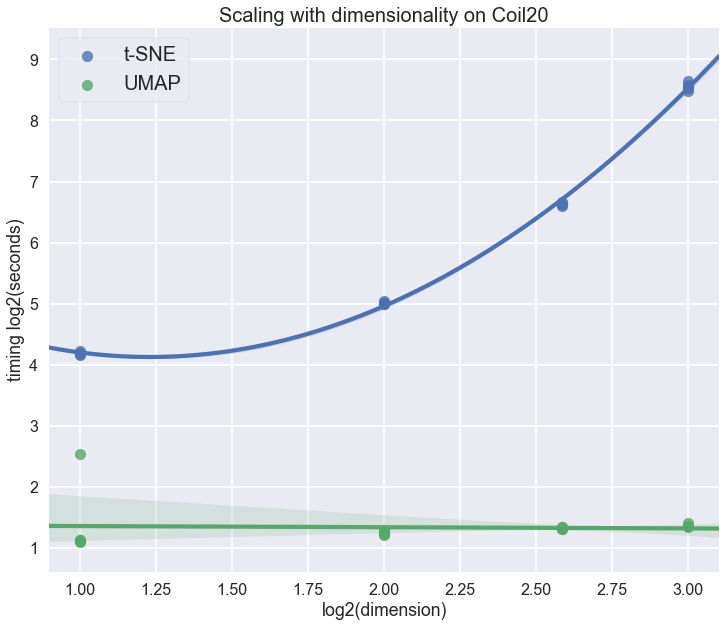

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.regplot(x='dimension',y='timing',data=np.log2(d_tsne),ax=ax, label='t-SNE', order=2)
sns.regplot(x='dimension',y='timing',data=np.log2(d_umap),ax=ax, label='UMAP')
plt.ylabel('timing log2(seconds)')
plt.xlabel('log2(dimension)')

plt.legend(loc='best', frameon=True, fancybox=True, fontsize=20)
plt.title('Scaling with dimensionality on Coil20', fontsize=20)
plt.savefig('scalingWithDimensionalityComparisonCoil20_log.png')

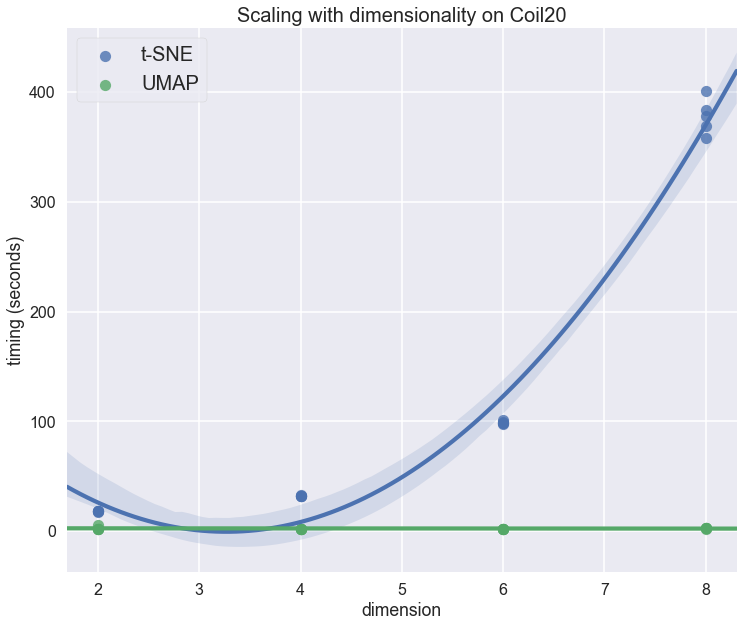

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.regplot(x='dimension',y='timing',data=d_tsne,ax=ax, label='t-SNE', order=2)
sns.regplot(x='dimension',y='timing',data=d_umap,ax=ax, label='UMAP')
plt.ylabel('timing (seconds)')

plt.legend(loc='best', frameon=True, fancybox=True, fontsize=20)
plt.title('Scaling with dimensionality on Coil20', fontsize=20)
plt.savefig('scalingWithDimensionalityComparisonCoil20.png')

## Test UMAP scaling to much higher dimensions.

In [16]:
large_timings = []
large_dims = []
dimensions = [2,4,8, 16, 32,64,128,256,512,1028]
for dim in dimensions:
    for rep in range(5):
        start = time.time()
        embedding = umap.UMAP(n_components=dim, n_neighbors=5, metric='euclidean').fit_transform(data)
        total_time = time.time()- start
        large_dims.append(dim)
        large_timings.append(total_time)
        print("dim: {} timing:{}".format(dim,total_time))

    

dim: 2 timing:2.211927890777588
dim: 2 timing:2.293887138366699
dim: 2 timing:2.243364095687866
dim: 2 timing:2.759848117828369
dim: 2 timing:2.2880780696868896
dim: 4 timing:2.3602120876312256
dim: 4 timing:2.485353946685791
dim: 4 timing:2.357630968093872
dim: 4 timing:2.3863019943237305
dim: 4 timing:2.345984935760498
dim: 8 timing:2.580812931060791
dim: 8 timing:2.6483068466186523
dim: 8 timing:2.8465700149536133
dim: 8 timing:2.6743199825286865
dim: 8 timing:2.7181050777435303
dim: 16 timing:2.8719370365142822
dim: 16 timing:2.794497013092041
dim: 16 timing:2.826751947402954
dim: 16 timing:2.8238649368286133
dim: 16 timing:2.789424180984497
dim: 32 timing:3.4809529781341553
dim: 32 timing:3.3034889698028564
dim: 32 timing:3.314910888671875
dim: 32 timing:3.339431047439575
dim: 32 timing:3.3027939796447754
dim: 64 timing:4.170777082443237
dim: 64 timing:4.236429929733276
dim: 64 timing:4.2281880378723145
dim: 64 timing:4.20123291015625
dim: 64 timing:4.217120170593262
dim: 128 timi

In [17]:
d_large = pd.DataFrame({'dimension':large_dims, 'timing':large_timings})

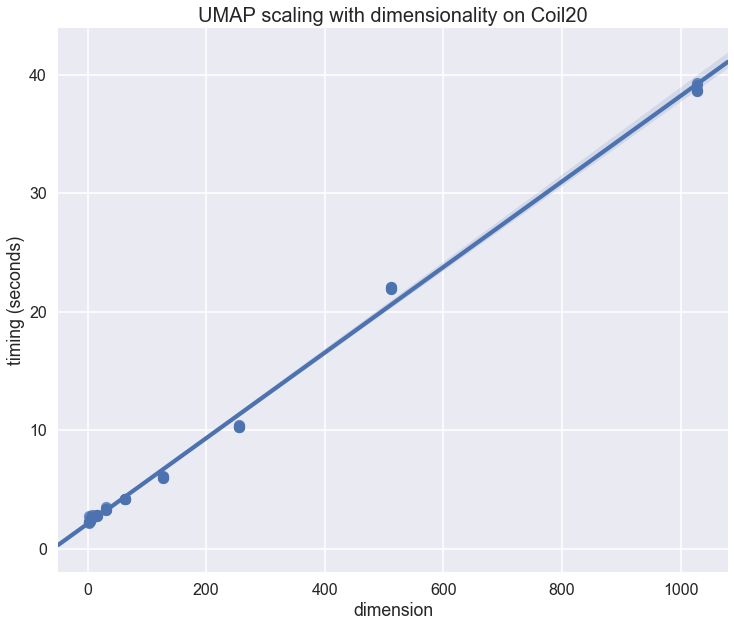

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.regplot(x='dimension',y='timing',data=d_large,ax=ax, label='UMAP')
plt.ylabel('timing (seconds)')
#plt.legend(loc='best', frameon=True, fancybox=True, fontsize=20)
plt.title('UMAP scaling with dimensionality on Coil20', fontsize=20)
plt.savefig('scalingWithDimensionalityUMAPCoil20.png')